In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Import librerie

In [ ]:
import scipy.io as sio
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import shutil
import copy
import random
from random import shuffle
import matplotlib.pyplot as plt
import cv2

In [2]:
 !cp gdrive/MyDrive/COLAB/TRAIN.zip /content/
 !cp gdrive/MyDrive/COLAB/TEST_SET.zip /content/


 !unzip TEST_SET.zip -d DATI/ 
 !unzip TRAIN.zip -d DATI/

 !rm DATI/TRAIN/Thumbs.db
 !rm DATI/TEST_SET/Thumbs.db


Archive:  TEST_SET.zip
  inflating: DATI/TEST_SET/2_1.png   
  inflating: DATI/TEST_SET/2_10.png  
  inflating: DATI/TEST_SET/2_100.png  
  inflating: DATI/TEST_SET/2_101.png  
  inflating: DATI/TEST_SET/2_102.png  
  inflating: DATI/TEST_SET/2_103.png  
  inflating: DATI/TEST_SET/2_104.png  
  inflating: DATI/TEST_SET/2_105.png  
  inflating: DATI/TEST_SET/2_106.png  
  inflating: DATI/TEST_SET/2_107.png  
  inflating: DATI/TEST_SET/2_108.png  
  inflating: DATI/TEST_SET/2_109.png  
  inflating: DATI/TEST_SET/2_11.png  
  inflating: DATI/TEST_SET/2_110.png  
  inflating: DATI/TEST_SET/2_111.png  
  inflating: DATI/TEST_SET/2_112.png  
  inflating: DATI/TEST_SET/2_113.png  
  inflating: DATI/TEST_SET/2_114.png  
  inflating: DATI/TEST_SET/2_115.png  
  inflating: DATI/TEST_SET/2_116.png  
  inflating: DATI/TEST_SET/2_117.png  
  inflating: DATI/TEST_SET/2_118.png  
  inflating: DATI/TEST_SET/2_119.png  
  inflating: DATI/TEST_SET/2_12.png  
  inflating: DATI/TEST_SET/2_120.png  
  infl

##Check device

In [ ]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

1.7.0+cu101
True
Tesla P4
cuda:0


##Definizione funzioni


In [ ]:

#find best model on validation test
def train_loop_validation(folder, dataloaders, startEpoch, numEpochs, model_conv, criterionCNN, learning_rate,
                          best_acc, best_loss, best_epoca, outputPath):
  
  optimizer_conv = optim.Adam(model_conv.classifier.parameters(), lr=learning_rate)
  scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=75, gamma=0.1)

  for epochs in range(startEpoch, numEpochs + 1):

    since = time.time()
    
    modelLoss_train = 0.0
    modelAcc_train = 0.0

    model_conv.train() 

    totalSize = 0
    
    
    #for each batch
    for inputs, labels in dataloaders[f"tutto_tranne_{folder}"]:
      inputs = inputs.type(torch.FloatTensor).cuda()
      labels = labels.cuda()
      optimizer_conv.zero_grad()
      model_conv.zero_grad()
      
      y = model_conv(inputs)
      outp, preds = torch.max(y, 1)   
        
      lossCNN = criterionCNN(y, labels) #media per batch

      modelLoss_train += lossCNN.item() * inputs.size(0)
      totalSize += inputs.size(0)
      modelAcc_train += torch.sum(preds == labels.data).item()

      lossCNN.backward()  # pred = f(x)   -> loss = L(f(x), l_true)
      optimizer_conv.step()
      
    
    
    modelLoss_epoch_train = modelLoss_train/totalSize
    modelAcc_epoch_train  = modelAcc_train/totalSize
    
    #salvataggio dei pesi ad ogni iterazione -> nel caso si blocchi e vogliamo riprendere il train 
    torch.save(model_conv.state_dict(), outputPath + f"train_weights_{folder}.pth")
    
    model_conv.eval()
    totalSize_val = 0
    modelLoss_val = 0.0
    modelAcc_val = 0.0

    for inputs, labels in dataloaders[f"{folder}"]:
      inputs = inputs.type(torch.FloatTensor).cuda()
      labels = labels.cuda()
      
      y = model_conv(inputs)
      outp, preds = torch.max(y, 1)
      lossCNN = criterionCNN(y, labels)

      modelLoss_val += lossCNN.item() * inputs.size(0)
      totalSize_val += inputs.size(0)
      modelAcc_val += torch.sum(preds == labels.data).item()
    
      
    modelLoss_epoch_val=modelLoss_val/totalSize_val
    modelAcc_epoch_val = modelAcc_val/totalSize_val
    time_elapsed = time.time()-since

    #print(time_elapsed)
    print('[Epoch %d][Fold %s][LR %f][TRAIN on %d [Loss: %.4f  ACC: %.4f]][VAL on %d [Loss: %.4f  ACC: %.4f]][TIME: %.0f m %.0f s]' 
          %(epochs, folder, optimizer_conv.param_groups[0]['lr'], totalSize, modelLoss_epoch_train, modelAcc_epoch_train, totalSize_val, modelLoss_epoch_val, 
            modelAcc_epoch_val, time_elapsed // 60, time_elapsed % 60))
    
    scheduler.step()
    
    #if epochs == 1 or modelLoss_epoch_val < best_loss:
    if (modelAcc_epoch_val > best_acc) or (modelAcc_epoch_val == best_acc and modelLoss_epoch_val < best_loss) :
      print('     .... Saving best weights ....')
      best_acc = modelAcc_epoch_val
      best_loss = modelLoss_epoch_val
      best_epoca = epochs
      #salvataggio dei migliori pesi sul validation
      torch.save(model_conv.state_dict(), outputPath + f"best_model_weights_{folder}.pth")
      
      # with open(outputPath + 'lossTrain.txt', "a") as file_object:
      #  file_object.write(str(modelLoss_epoch_train) +'\n')
      
      # with open(outputPath + 'AccTrain.txt', "a") as file_object:
      #  file_object.write(str(modelAcc_epoch_train)+'\n')
      
      # with open(outputPath + 'lossVal.txt', "a") as file_object:
      #   file_object.write(str(modelLoss_epoch_val)+'\n')
      
      # with open(outputPath + 'AccVal.txt', "a") as file_object:
      #   file_object.write(str(modelAcc_epoch_val)+'\n')
      
    sio.savemat(outputPath + f"check_point_{folder}.mat", {'best_acc': best_acc, 
                                                 'best_loss': best_loss,
                                                 'best_epoca': best_epoca,
                                                 'last_epoch': epochs})
    
def train_loop_validation_classic(dataloaders, startEpoch, numEpochs, model_conv, criterionCNN, optimizer_conv,
                          best_acc, best_loss, best_epoca, outputPath):
  
  optimizer_conv = optim.Adam(model_conv.classifier.parameters(), lr=learning_rate)
  scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=75, gamma=0.1)

  for epochs in range(startEpoch, numEpochs + 1):
    
    since = time.time()
    
    modelLoss_train = 0.0
    modelAcc_train = 0.0
    
    model_conv.train() 
    
    totalSize = 0
    
    
    #for each batch
    for inputs, labels in dataloaders['train_set_model']:
      
      inputs = inputs.type(torch.FloatTensor).cuda()
      
      labels = labels.cuda()
      
      
      
      optimizer_conv.zero_grad()
      
      model_conv.zero_grad()
      
      y = model_conv(inputs)
      outp, preds = torch.max(y, 1)   
        
      lossCNN = criterionCNN(y, labels) #media per batch

      modelLoss_train += lossCNN.item() * inputs.size(0)
      totalSize += inputs.size(0)
      modelAcc_train += torch.sum(preds == labels.data).item()

      lossCNN.backward()
      optimizer_conv.step()
    
    
    modelLoss_epoch_train = modelLoss_train/totalSize
    modelAcc_epoch_train  = modelAcc_train/totalSize
    
    #salvataggio dei pesi ad ogni iterazione -> nel caso si blocchi e vogliamo riprendere il train 
    torch.save(model_conv.state_dict(), outputPath + 'train_weights.pth')
    
    model_conv.eval()
    totalSize_val = 0
    modelLoss_val = 0.0
    modelAcc_val = 0.0

    for inputs, labels in dataloaders['validation_set_model']:
      inputs = inputs.type(torch.FloatTensor).cuda()
      labels = labels.cuda()
      
      
      y = model_conv(inputs)
      outp, preds = torch.max(y, 1)
      lossCNN = criterionCNN(y, labels)

      modelLoss_val += lossCNN.item() * inputs.size(0)
      totalSize_val += inputs.size(0)
      modelAcc_val += torch.sum(preds == labels.data).item()
    
      
    modelLoss_epoch_val=modelLoss_val/totalSize_val
    modelAcc_epoch_val = modelAcc_val/totalSize_val
    time_elapsed = time.time()-since

    #print(time_elapsed)
    print('[Epoch %d][TRAIN on %d] [LR %f] [Loss: %.4f  ACC: %.4f]][VAL on %d [Loss: %.4f  ACC: %.4f]][TIME: %.0f m %.0f s]' 
          %(epochs, totalSize,optimizer_conv.param_groups[0]['lr'], modelLoss_epoch_train, modelAcc_epoch_train, totalSize_val, modelLoss_epoch_val, 
            modelAcc_epoch_val, time_elapsed // 60, time_elapsed % 60))
    
    scheduler.step()
    
    #if epochs == 1 or modelLoss_epoch_val < best_loss:
    if (modelAcc_epoch_val > best_acc) or (modelAcc_epoch_val == best_acc and modelLoss_epoch_val < best_loss) :
      print('     .... Saving best weights ....')
      best_acc = modelAcc_epoch_val
      best_loss = modelLoss_epoch_val
      best_epoca = epochs
      #salvataggio dei migliori pesi sul validation
      torch.save(model_conv.state_dict(), outputPath + 'best_model_weights.pth')
      
    with open(outputPath + 'lossTrain.txt', "a") as file_object:
      file_object.write(str(modelLoss_epoch_train) +'\n')
      
    with open(outputPath + 'AccTrain.txt', "a") as file_object:
      file_object.write(str(modelAcc_epoch_train)+'\n')
      
    with open(outputPath + 'lossVal.txt', "a") as file_object:
      file_object.write(str(modelLoss_epoch_val)+'\n')
      
    with open(outputPath + 'AccVal.txt', "a") as file_object:
      file_object.write(str(modelAcc_epoch_val)+'\n')
      
    sio.savemat(outputPath + 'check_point.mat', {'best_acc': best_acc, 
                                                 'best_loss': best_loss,
                                                 'best_epoca': best_epoca,
                                                 'last_epoch': epochs})
    
def train_loop(dataloaders, startEpoch, numEpochs, model_conv, criterionCNN, learning_rate,
                          best_acc, best_loss, best_epoca, outputPath):
  
  optimizer_conv = optim.Adam(model_conv.classifier.parameters(), lr=learning_rate)
  scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=75, gamma=0.1)

  for epochs in range(startEpoch, numEpochs + 1):
    since = time.time()
    
    modelLoss_train = 0.0
    modelAcc_train = 0.0

    model_conv.train() 

    totalSize = 0
    
    
    #for each batch
    for inputs, labels in dataloaders:
      inputs = inputs.type(torch.FloatTensor).cuda()
      labels = labels.cuda()
      
      optimizer_conv.zero_grad()
      
      model_conv.zero_grad()
      
      y = model_conv(inputs)
      outp, preds = torch.max(y, 1)   
        
      lossCNN = criterionCNN(y, labels) #media per batch

      modelLoss_train += lossCNN.item() * inputs.size(0)
      totalSize += inputs.size(0)
      modelAcc_train += torch.sum(preds == labels.data).item()

      lossCNN.backward()
      optimizer_conv.step()
    
    
    modelLoss_epoch_train = modelLoss_train/totalSize
    modelAcc_epoch_train  = modelAcc_train/totalSize
    
    #salvataggio dei pesi ad ogni iterazione -> nel caso si blocchi e vogliamo riprendere il train 
    torch.save(model_conv.state_dict(), outputPath + 'train_weights.pth')
    
    model_conv.eval()
    totalSize_val = 0
    modelLoss_val = 0.0
    modelAcc_val = 0.0

    for inputs, labels in dataloaders:
      inputs = inputs.type(torch.FloatTensor).cuda()
      labels = labels.cuda()
      
      y = model_conv(inputs)
      outp, preds = torch.max(y, 1)
      lossCNN = criterionCNN(y, labels)

      modelLoss_val += lossCNN.item() * inputs.size(0)
      totalSize_val += inputs.size(0)
      modelAcc_val += torch.sum(preds == labels.data).item()
    
      
    modelLoss_epoch_val=modelLoss_val/totalSize_val
    modelAcc_epoch_val = modelAcc_val/totalSize_val
    time_elapsed = time.time()-since

    #print(time_elapsed)
    print('[Epoch %d][TRAIN on %d] [LR %f] [Loss: %.4f  ACC: %.4f]][VAL on %d [Loss: %.4f  ACC: %.4f]][TIME: %.0f m %.0f s]' 
          %(epochs, totalSize,optimizer_conv.param_groups[0]['lr'], modelLoss_epoch_train, modelAcc_epoch_train, totalSize_val, modelLoss_epoch_val, 
            modelAcc_epoch_val, time_elapsed // 60, time_elapsed % 60))
    
    scheduler.step()
    
    #if epochs == 1 or modelLoss_epoch_val < best_loss:
    #if (modelAcc_epoch_val > best_acc) or (modelAcc_epoch_val == best_acc and modelLoss_epoch_val < best_loss) :
  print('     .... Saving final weights ....')
      #best_acc = modelAcc_epoch_val
      #best_loss = modelLoss_epoch_val
      #best_epoca = epochs
      #salvataggio dei migliori pesi sul validation
  torch.save(model_conv.state_dict(), outputPath + 'def_model_weights.pth')
      
    # with open(outputPath + 'lossTrain.txt', "a") as file_object:
    #   file_object.write(str(modelLoss_epoch_train) +'\n')
      
    # with open(outputPath + 'AccTrain.txt', "a") as file_object:
    #   file_object.write(str(modelAcc_epoch_train)+'\n')
      
    # with open(outputPath + 'lossVal.txt', "a") as file_object:
    #   file_object.write(str(modelLoss_epoch_val)+'\n')
      
    # with open(outputPath + 'AccVal.txt', "a") as file_object:
    #   file_object.write(str(modelAcc_epoch_val)+'\n')
      
    # sio.savemat(outputPath + 'check_point.mat', {'best_acc': best_acc, 
    #                                              'best_loss': best_loss,
    #                                              'best_epoca': best_epoca,
    #                                              'last_epoch': epochs})

##Parametri

In [ ]:
#rendere l'esecuzione deterministica
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


learning_rate = 0.00001
batch_size = 32
set_classes_number = 2
num_epoch = 100

#Creazione folder

In [ ]:
!rm -rf /content/dati/TRAIN/.ipynb_checkpoints



folder_type = ['Acquisizione1', 'Acquisizione3', 'Acquisizione5','Acquisizione6','Acquisizione7','KFM_FLOTAC']
extra_folder = ['tutto_tranne_Acquisizione1','tutto_tranne_Acquisizione3','tutto_tranne_Acquisizione5','tutto_tranne_Acquisizione6','tutto_tranne_Acquisizione7','tutto_tranne_KFM_FLOTAC']
# extra_folder = ['tutto_tranne_1','tutto_tranne_2','tutto_tranne_3','tutto_tranne_4','tutto_tranne_5','tutto_tranne_6','tutto_tranne_7']
# folder_type = ['1', '2','3','4','5','6','7']

from PIL import Image
import glob
files_list_empty = []
files_list_uovo = []
for filename in glob.glob('/content/DATI/TRAIN/empty/*.png'):
    im=Image.open(filename)
    files_list_empty.append(im)
for filename in glob.glob('/content/DATI/TRAIN/uovo/*.png'):
    im=Image.open(filename)
    files_list_uovo.append(im)

print(len(files_list_uovo))


# Check if directory exists. If not, create it
for folder in folder_type:
    if os.path.isdir(f"./{folder}"):
        pass
    else:
        os.mkdir(f"./{folder}")
        os.mkdir(f"./{folder}/empty")
        os.mkdir(f"./{folder}/uovo")
       
for folder in extra_folder:
    if os.path.isdir(f"./{folder}"):
        pass
    else:
        os.mkdir(f"./{folder}")
        os.mkdir(f"./{folder}/empty")
        os.mkdir(f"./{folder}/uovo")


# Check if directory exists. If not, create it

  

# for fname in files_list:
#   print(fname.filename)

for fname in files_list_empty:  # traverse the files list
  # if 'Acquisizione6' in fname.filename:
  #   shutil.copy(f"/{fname.filename}", f"/content/val_train_set_model/empty")
  #   shutil.copy(f"/{fname.filename}", f"/content/validation_set_model/empty") # copy it to the respective directory
  # elif 'Acquisizione7' in fname.filename:
  #   shutil.copy(f"/{fname.filename}", "/content/test_set_model/empty") # copy it to the respective directory
  # elif 'KFM_FLOTAC' in fname.filename:
  #   shutil.copy(f"/{fname.filename}", "/content/test_set_model/empty") # copy it to the respective directory
  # else:
  #   shutil.copy(f"/{fname.filename}", f"/content/val_train_set_model/empty")
  #   shutil.copy(f"/{fname.filename}", "/content/train_set_model/empty") # copy it to the respective directory
  for folder in folder_type:
    if folder in fname.filename:
      shutil.copy(f"/{fname.filename}", f"/content/{folder}/empty")
      for extra in extra_folder:
       if extra!= f'tutto_tranne_{folder}':
         shutil.copy(f"/{fname.filename}", f"/content/{extra}/empty")

for fname in files_list_uovo:  # traverse the files list
  # if 'Acquisizione6' in fname.filename:
  #   shutil.copy(f"/{fname.filename}", f"/content/val_train_set_model/uovo")
  #   shutil.copy(f"/{fname.filename}", f"/content/validation_set_model/uovo") # copy it to the respective directory
  # elif 'Acquisizione7' in fname.filename:
  #   shutil.copy(f"/{fname.filename}", "/content/test_set_model/uovo") # copy it to the respective directory
  # elif 'KFM_FLOTAC' in fname.filename:
  #   shutil.copy(f"/{fname.filename}", "/content/test_set_model/uovo") # copy it to the respective directory
  # else:
  #   shutil.copy(f"/{fname.filename}", f"/content/val_train_set_model/uovo")
  #   shutil.copy(f"/{fname.filename}", "/content/train_set_model/uovo") # copy it to the respective directory
  for folder in folder_type:
    if folder in fname.filename:
      shutil.copy(f"/{fname.filename}", f"/content/{folder}/uovo")
      for extra in extra_folder:
       if extra!= f'tutto_tranne_{folder}':
         shutil.copy(f"/{fname.filename}", f"/content/{extra}/uovo")


###############################################################################
# k=0

# for fname in files_list_empty:  # traverse the files list
#   n=int(k/124)
#   shutil.copy(f"/{fname.filename}", f"/content/{str(n+1)}/empty")
#   for folder in folder_type:
#     if (int(folder) != n+1):
#       shutil.copy(f"/{fname.filename}", f"/content/tutto_tranne_{folder}/empty")
#   k=k+1
    
# k=0

# for fname in files_list_uovo:  # traverse the files list
#   n=int(k/122)
#   shutil.copy(f"/{fname.filename}", f"/content/{str(n+1)}/uovo")
#   for folder in folder_type:
#     if (int(folder) != n+1):
#       shutil.copy(f"/{fname.filename}", f"/content/tutto_tranne_{folder}/uovo")
#   if k==800:
#     k=k-1
#   k=k+1


# Print contents of each folder
for folder in folder_type:
    for i in ['empty','uovo']:
      print(f"\n\nContents of {folder}/{i}::::")
      print(len(os.listdir(f"./{folder}/{i}")))

for folder in extra_folder:
    for i in ['empty','uovo']:
      print(f"\n\nContents of {folder}/{i}::::")
      print(len(os.listdir(f"./{folder}/{i}")))



# simple version for working with CWD
# print len([name for name in os.listdir('.') if os.path.isfile(name)])

In tutto abbiamo 1722 immagini, facciamo validation set = Acquisizione6 (302) -> 17.5% e test set= Acquisizione7 (204) + KFM_FLOTAC(110) -> 18.2 %
Rimane il resto -> 64.2% per il training set  

#Creazione folder alternativa

Creo 7 folder stratificati ciascuno da 246 immagini.
Uno sarà il nostro test, gli altri 6 li usiamo per una sorta di cross validation e ognuno di essi avrà 124 empty e 122 egg, il test avrà 123 di entrambi

In [ ]:
import random

!rm -rf /content/dati/TRAIN/.ipynb_checkpoints

folder_type = ['train_set_model', 'validation_set_model','test_set_model','val_train_set_model']

from PIL import Image
import glob
files_list_empty = []
files_list_uovo = []
for filename in glob.glob('/content/DATI/TRAIN/empty/*.png'):
    im=Image.open(filename)
    files_list_empty.append(im)
for filename in glob.glob('/content/DATI/TRAIN/uovo/*.png'):
    im=Image.open(filename)
    files_list_uovo.append(im)

print(len(files_list_empty))

random.shuffle(files_list_empty)
random.shuffle(files_list_uovo)

# Check if directory exists. If not, create it
for folder in folder_type:
    if os.path.isdir(f"./{folder}"):
        pass
    else:
        os.mkdir(f"./{folder}")
        os.mkdir(f"./{folder}/empty")
        os.mkdir(f"./{folder}/uovo")
       
# for folder in extra_folder:
#     if os.path.isdir(f"./{folder}"):
#         pass
#     else:
#         os.mkdir(f"./{folder}")
#         os.mkdir(f"./{folder}/empty")
#         os.mkdir(f"./{folder}/uovo")
       


# Check if directory exists. If not, create it

n_empty = len(files_list_empty)
n_uovo = len(files_list_uovo)


n_train_val_uovo = int(n_uovo*0.75)
n_test_uovo = n_uovo - n_train_val_uovo

n_train_uovo = int(n_train_val_uovo*0.75)
n_val_uovo = n_train_val_uovo - n_train_uovo

n_train_val_empty = int(n_empty*0.75)
n_test_empty = n_empty - n_train_val_empty

n_train_empty = int(n_train_val_empty*0.75)
n_val_empty = n_train_val_empty - n_train_empty



# for fname in files_list:
#   print(fname.filename)

k=0

for fname in files_list_uovo:  # traverse the files list
   if 'Acquisizione6' in fname.filename:
    # shutil.copy(f"/{fname.filename}", "/content/val_train_set_model/uovo")
    shutil.copy(f"/{fname.filename}", "/content/test_set_model/uovo") # copy it to the respective directory
   elif 'Acquisizione7' in fname.filename:
    shutil.copy(f"/{fname.filename}", "/content/validation_set_model/uovo") # copy it to the respective directory
    shutil.copy(f"/{fname.filename}", "/content/val_train_set_model/uovo")
   elif 'KFM_FLOTAC' in fname.filename:
    shutil.copy(f"/{fname.filename}", "/content/validation_set_model/uovo") # copy it to the respective directory
    shutil.copy(f"/{fname.filename}", "/content/val_train_set_model/uovo")
   else:
    shutil.copy(f"/{fname.filename}", "/content/val_train_set_model/uovo")
    shutil.copy(f"/{fname.filename}", "/content/train_set_model/uovo") # copy it to the respective directory
  # if k<n_train_uovo :
  #   shutil.copy(f"/{fname.filename}", "/content/val_train_set_model/uovo")
  #   shutil.copy(f"/{fname.filename}", "/content/train_set_model/uovo")
  # elif k<n_train_val_uovo :
  #   shutil.copy(f"/{fname.filename}", "/content/val_train_set_model/uovo")
  #   shutil.copy(f"/{fname.filename}", "/content/validation_set_model/uovo")
  # else:
  #   shutil.copy(f"/{fname.filename}", "/content/test_set_model/uovo")
  # k = k+1
  


 
k=0


for fname in files_list_empty:  # traverse the files list
  if 'Acquisizione6' in fname.filename:
    # shutil.copy(f"/{fname.filename}", "/content/val_train_set_model/empty")
    shutil.copy(f"/{fname.filename}", "/content/test_set_model/empty") # copy it to the respective directory
  elif 'Acquisizione7' in fname.filename:
    shutil.copy(f"/{fname.filename}", "/content/validation_set_model/empty") # copy it to the respective directory
    shutil.copy(f"/{fname.filename}", "/content/val_train_set_model/empty")
  elif 'KFM_FLOTAC' in fname.filename:
    shutil.copy(f"/{fname.filename}", "/content/validation_set_model/empty") # copy it to the respective directory
    shutil.copy(f"/{fname.filename}", "/content/val_train_set_model/empty")
  else:
    shutil.copy(f"/{fname.filename}", f"/content/val_train_set_model/empty")
    shutil.copy(f"/{fname.filename}", "/content/train_set_model/empty") # copy it to the respective directory
  # if k<n_train_empty :
  #   shutil.copy(f"/{fname.filename}", "/content/val_train_set_model/empty")
  #   shutil.copy(f"/{fname.filename}", "/content/train_set_model/empty")
  # elif k<n_train_val_empty :
  #   shutil.copy(f"/{fname.filename}", "/content/val_train_set_model/empty")
  #   shutil.copy(f"/{fname.filename}", "/content/validation_set_model/empty")
  # else:
  #   shutil.copy(f"/{fname.filename}", "/content/test_set_model/empty")
  # k = k+1

# Print contents of each folder
for folder in folder_type:
    for i in ['empty','uovo']:
      print(f"\nNumero di elementi nel folder {folder}/{i} ->")
      print(len(os.listdir(f"./{folder}/{i}")))

# for folder in extra_folder:
#     for i in ['empty','uovo']:
#       print(f"\n\nContents of {folder}/{i}::::")
#       print(len(os.listdir(f"./{folder}/{i}")))


# simple version for working with CWD
# print len([name for name in os.listdir('.') if os.path.isfile(name)])

867

Numero di elementi nel folder train_set_model/empty ->
487

Numero di elementi nel folder train_set_model/uovo ->
480

Numero di elementi nel folder validation_set_model/empty ->
163

Numero di elementi nel folder validation_set_model/uovo ->
161

Numero di elementi nel folder test_set_model/empty ->
217

Numero di elementi nel folder test_set_model/uovo ->
214

Numero di elementi nel folder val_train_set_model/empty ->
650

Numero di elementi nel folder val_train_set_model/uovo ->
641


##Caricamento dati


In [ ]:
#How to improve?? 
data_transforms = {
    'train_set_model': transforms.Compose([transforms.Resize(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomVerticalFlip(),
                                 #transforms.ColorJitter(),
                                 #transforms.RandomRotation(90),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                 ]),
    'validation_set_model': transforms.Compose([ transforms.Resize(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ])
                   }

data_dir = '/content'

image_datasets = {y: datasets.ImageFolder(os.path.join(data_dir, y),data_transforms[x]) for x,y in zip(['train_set_model', 'validation_set_model','train_set_model', 'validation_set_model','train_set_model', 'validation_set_model','train_set_model', 'validation_set_model','train_set_model', 'validation_set_model','train_set_model', 'validation_set_model'],['tutto_tranne_Acquisizione1','Acquisizione1','tutto_tranne_Acquisizione3','Acquisizione3','tutto_tranne_Acquisizione5','Acquisizione5','tutto_tranne_Acquisizione6','Acquisizione6','tutto_tranne_Acquisizione7','Acquisizione7','tutto_tranne_KFM_FLOTAC','KFM_FLOTAC'])}

dataloaders = {y: torch.utils.data.DataLoader(image_datasets[y], batch_size=batch_size,shuffle=True, num_workers=4) for y in ['tutto_tranne_Acquisizione1','Acquisizione1','tutto_tranne_Acquisizione3','Acquisizione3','tutto_tranne_Acquisizione5','Acquisizione5','tutto_tranne_Acquisizione6','Acquisizione6','tutto_tranne_Acquisizione7','Acquisizione7','tutto_tranne_KFM_FLOTAC','KFM_FLOTAC']}
dataset_sizes = {y: len(image_datasets[y]) for y in ['tutto_tranne_Acquisizione1','Acquisizione1','tutto_tranne_Acquisizione3','Acquisizione3','tutto_tranne_Acquisizione5','Acquisizione5','tutto_tranne_Acquisizione6','Acquisizione6','tutto_tranne_Acquisizione7','Acquisizione7','tutto_tranne_KFM_FLOTAC','KFM_FLOTAC']}
class_names = (image_datasets['tutto_tranne_Acquisizione1'].classes)
print(class_names)


print(image_datasets['Acquisizione1'].classes)
print(dataset_sizes['tutto_tranne_Acquisizione1'])
print(dataset_sizes['Acquisizione1'])


#########################################################################################

# image_datasets = {y: datasets.ImageFolder(os.path.join(data_dir, y),data_transforms[x]) for x,y in zip(['train_set_model', 'validation_set_model','train_set_model', 'validation_set_model','train_set_model', 'validation_set_model','train_set_model', 'validation_set_model','train_set_model', 'validation_set_model','train_set_model', 'validation_set_model','train_set_model','validation_set_model'],['tutto_tranne_1','1','tutto_tranne_2','2','tutto_tranne_3','3','tutto_tranne_4','4','tutto_tranne_5','5','tutto_tranne_6','6','tutto_tranne_7','7'])}

# dataloaders = {y: torch.utils.data.DataLoader(image_datasets[y], batch_size=batch_size,shuffle=True, num_workers=4) for y in ['tutto_tranne_1','1','tutto_tranne_2','2','tutto_tranne_3','3','tutto_tranne_4','4','tutto_tranne_5','5','tutto_tranne_6','6','tutto_tranne_7','7']}
# dataset_sizes = {y: len(image_datasets[y]) for y in ['tutto_tranne_1','1','tutto_tranne_2','2','tutto_tranne_3','3','tutto_tranne_4','4','tutto_tranne_5','5','tutto_tranne_6','6','tutto_tranne_7','7']}
# class_names = (image_datasets['tutto_tranne_1'].classes)
# print(class_names)


# print(image_datasets['1'].classes)
# print(dataset_sizes['tutto_tranne_1'])
# print(dataset_sizes['1'])

# '''
# - CREAZIONE DEL DATASET
# - CREATO MODELLO 
# - FASE DI ADDESTRAMENTO 
#     - EPOCHE, LR, BATCH SIZE, ....

#     - PER OGNI EPOCA
#        - PREPARO I DATI (SHUFFLE, DIVISIONE IN BATCH)
#        - PER OGNI BATCH:
#            - METTO I DATI IN INGRESSO ALLA RETE
#            - CALCOLO LOSS
#            - CALCOLO GRADIENTI
#            - AGGIORNO I PESI  
#        - VALUTO LE PRESTAZIONI SUL VALIDATION SET. 
# '''

FileNotFoundError: ignored

#Caricamento dati 2

In [ ]:
data_transforms = {
    'train_set_model': transforms.Compose([transforms.Resize(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomVerticalFlip(),
                                 #transforms.ColorJitter(),
                                 #transforms.RandomRotation(90),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                 ]),
    'validation_set_model': transforms.Compose([ transforms.Resize(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ])
                   }

data_dir = '/content'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train_set_model', 'validation_set_model']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,shuffle=True, num_workers=4) for x in ['train_set_model', 'validation_set_model']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train_set_model', 'validation_set_model']}
class_names = (image_datasets['train_set_model'].classes)
print(class_names)

print(dataloaders['train_set_model'])

print(image_datasets['validation_set_model'].classes)
print(dataset_sizes['train_set_model'])
print(dataset_sizes['validation_set_model'])







['empty', 'uovo']
['empty', 'uovo']
967
324


##Train model

In [ ]:
networkName = 'vgg11'
WeightPath = '/content/' + networkName + '/'



try:
  os.makedirs(WeightPath)
except:
  pass

model_conv = torchvision.models.vgg11(pretrained=True)
# change last fully connected layer
model_conv.classifier[6] = nn.Linear(4096, set_classes_number)

# set requires_grad=false
for param in model_conv.parameters():
  param.requires_grad = True

# train fully connected layers
for param in model_conv.classifier.parameters():
  param.requires_grad = True
model_conv = model_conv.cuda()
print(model_conv)
criterion = nn.CrossEntropyLoss()
# optimizer_conv = optim.Adam(model_conv.classifier.parameters(), lr=learning_rate)

# -------------------------------------------------------------------------------------  train model


#train_loop_validation(dataloaders, startEpoch, num_epoch, model_conv, criterion, optimizer_conv, best_acc, best_loss, best_epoca, WeightPath)

startEpoch =1
best_acc = 0
best_loss=0
best_epoca = 0
print("aooo")
train_loop_validation_classic(dataloaders, startEpoch, num_epoch, model_conv, criterion, learning_rate, best_acc, best_loss, best_epoca, WeightPath)


Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/hub/checkpoints/vgg11-bbd30ac9.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Train model 2

##Curve

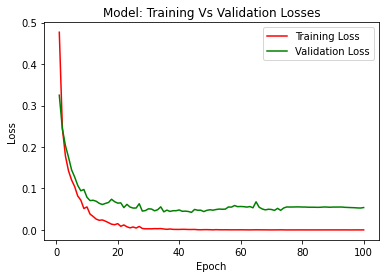

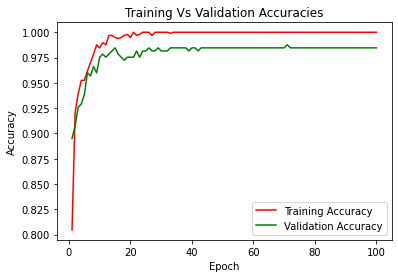

In [ ]:
lossModel_Train = []
lossModel_val = []
accModel_Train = []
accModel_val = []

file = open(WeightPath + 'lossTrain.txt', 'r')
Testo = file.readlines()
for element in Testo:
  lossModel_Train.append(float(element))

file = open(WeightPath + 'lossVal.txt', 'r')
Testo = file.readlines()
for element in Testo:
  lossModel_val.append(float(element))

plt.figure()
plt.title("Model: Training Vs Validation Losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(list(range(1,len(lossModel_Train)+1)), lossModel_Train, color='r', label="Training Loss")
plt.plot(list(range(1, len(lossModel_val)+1)), lossModel_val, color='g', label="Validation Loss")
plt.legend()
plt.savefig(WeightPath + 'LossTrainVal.png')

file = open(WeightPath + 'AccTrain.txt', 'r')
Testo = file.readlines()
for element in Testo:
  accModel_Train.append(float(element))

file = open(WeightPath + 'AccVal.txt', 'r')
Testo = file.readlines()
for element in Testo:
  accModel_val.append(float(element))

plt.figure()
plt.title("Training Vs Validation Accuracies")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(list(range(1, len(accModel_Train)+1)), accModel_Train, color='r', label="Training Accuracy")
plt.plot(list(range(1, len(accModel_val)+1)), accModel_val, color='g', label="Validation Accuracy")
plt.legend()
plt.savefig(WeightPath + 'AccTrainVal.png')

#Riaddestro su train+validation


In [ ]:
networkName = 'vgg11'
WeightPath = '/content/' + networkName + '/'

try:
  os.makedirs(WeightPath)
except:
  pass
  
model_conv = torchvision.models.vgg11(pretrained=True)
# change last fully connected layer
model_conv.classifier[6] = nn.Linear(4096, set_classes_number)

# set requires_grad=false
for param in model_conv.parameters():
  param.requires_grad = True
  
# train fully connected layers
for param in model_conv.classifier.parameters():
  param.requires_grad = True

print(model_conv)

model_conv = model_conv.cuda()
criterion = nn.CrossEntropyLoss()
# optimizer_conv = optim.Adam(model_conv.classifier.parameters(), lr=learning_rate)

mat = sio.loadmat('/content/vgg11/check_point.mat')
print(mat)
best_epoca = int(mat['best_epoca'])
print(best_epoca)

########################################################

# image_datasets = datasets.ImageFolder(os.path.join(data_dir, 'val_train_set_model'),data_transforms['train_set_model'])
# dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=batch_size,shuffle=True, num_workers=4)
# dataset_sizes = len(image_datasets)
# class_names = (image_datasets.classes)
# print(class_names)
# print(image_datasets.classes)
# print(dataset_sizes)

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, y),data_transforms[x]) for x,y in zip(['train_set_model', 'validation_set_model'],['val_train_set_model','test_set_model'])}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,shuffle=True, num_workers=4) for x in ['train_set_model', 'validation_set_model']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train_set_model', 'validation_set_model']}
class_names = (image_datasets['train_set_model'].classes)
print(class_names)


######################################################

# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, y),data_transforms[x]) for x,y in zip(['train_set_model', 'validation_set_model'],['tutto_tranne_7','7'])}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,shuffle=True, num_workers=4) for x in ['train_set_model', 'validation_set_model']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train_set_model', 'validation_set_model']}
# class_names = (image_datasets['train_set_model'].classes)

# -------------------------------------------------------------------------------------  train model
startEpoch =1
best_acc = 0
best_loss=0
best_epocaa = 0

train_loop_validation_classic(dataloaders, startEpoch, 44, model_conv, criterion, learning_rate, best_acc, best_loss, best_epocaa, WeightPath)
#train_loop(dataloaders, startEpoch, 23, model_conv, criterion, learning_rate, best_acc, best_loss, best_epocaa, WeightPath)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

##Valutazione sul Test Set

In [ ]:
from PIL import Image


Test = pd.DataFrame()

classes = class_names
#WeightPath = '/content/' + networkName


#model_conv = torchvision.models.googlenet(pretrained=True)
#model_conv.fc = nn.Linear(1024, set_classes_number)

listImage_uovo = os.listdir('/content/test_set_model/uovo')
listImage_empty = os.listdir('/content/test_set_model/empty')

for input in listImage_uovo:
  Test = Test.append({'img': input.split('.')[0],
                      'Class' : 'uovo'}, ignore_index = True)

for input in listImage_empty:
   Test = Test.append({'img': input.split('.')[0],
                      'Class' : 'empty'}, ignore_index = True)


#for folder in folder_type:
predizioni = []
model_conv = torchvision.models.vgg11(pretrained=True)
model_conv.classifier[6] = nn.Linear(4096, set_classes_number)
model_conv.load_state_dict(torch.load(WeightPath + '/best_model_weights.pth'))
#model_conv.load_state_dict(torch.load('/content/vgg11/def_model_weights.pth'))
#model_conv.load_state_dict(torch.load(f'/content/alexnet/best_model_weights_{folder}.pth'))
model_conv = model_conv.cuda()
model_conv.eval()

data_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                       ])



  
for input in listImage_uovo:
  print('Working on '+ input)
  img = Image.open('/content/DATI/TRAIN/uovo/' + input)
  img = data_transforms(img).to(device)
  img = img.unsqueeze_(0)
  outputs = model_conv(img)
  _, predicted = torch.max(outputs, 1)
    # Test = Test.append({f'predicted_{str(i)}': (classes[predicted.item()])},
    #                    ignore_index = True)
  predizioni.append(classes[predicted.item()])
    
             
for input in listImage_empty:
  print('Working on fff '+ input)
  img = Image.open('/content/DATI/TRAIN/empty/' + input)
  img = data_transforms(img).to(device)
  img = img.unsqueeze_(0)
  outputs = model_conv(img)
  _, predicted = torch.max(outputs, 1)
    # Test = Test.append({f'predicted_{str(i)}': (classes[predicted.item()])},
    #                    ignore_index = True)
  predizioni.append(classes[predicted.item()])

Test['predicted'] = predizioni


  


Working on Acquisizione3_micro_02_06_3_ADX.png
Working on Acquisizione3_micro_05_00_2_ADX.png
Working on KFM_FLOTAC_FLOTAC KFM (14)_2_ASX.png
Working on KFM_FLOTAC_FLOTAC KFM (11)_4_BSX.png
Working on Acquisizione5_micro_01_00_2_ASX.png
Working on Acquisizione5_micro_01_00_2_BSX.png
Working on Acquisizione3_micro_08_01_2_ASX.png
Working on Qualita2_Mini-KFM (3)_2_ADX.png
Working on Acquisizione3_micro_01_04_1_ADX.png
Working on Acquisizione1_micro_03_05_1_BSX.png
Working on Acquisizione3_micro_03_00_1_ADX.png
Working on KFM_FLOTAC_FLOTAC KFM (20)_2_ADX.png
Working on Acquisizione1_micro_08_04_2_BDX.png
Working on Acquisizione1_micro_02_01_1_ASX.png
Working on Acquisizione1_micro_08_07_1_BSX.png
Working on Acquisizione3_micro_01_04_2_BSX.png
Working on Acquisizione6_micro_01_09_3_central.png
Working on KFM_FLOTAC_FLOTAC KFM (12)_1_ADX.png
Working on Acquisizione6_micro_06_09_2_central.png
Working on Acquisizione6_micro_08_11_1_BDX.png
Working on Acquisizione3_micro_09_01_1_ASX.png
Worki

In [ ]:
# import itertools
# import operator

# def most_common(L):
#   # get an iterable of (item, iterable) pairs
#   SL = sorted((x, i) for i, x in enumerate(L))
#   # print 'SL:', SL
#   groups = itertools.groupby(SL, key=operator.itemgetter(0))
#   # auxiliary function to get "quality" for an item
#   def _auxfun(g):
#     item, iterable = g
#     count = 0
#     min_index = len(L)
#     for _, where in iterable:
#       count += 1
#       min_index = min(min_index, where)
#     # print 'item %r, count %r, minind %r' % (item, count, min_index)
#     return count, -min_index
#   # pick the highest-count/earliest item
#   return max(groups, key=_auxfun)[0]

# predizioni_ok = []
# for index, row in Test.iterrows():
#   predizioni_temp = []
#   for folder in folder_type:
#     predizioni_temp.append(row[f'predizioni_{folder}'])
#   predizioni_ok.append(most_common(predizioni_temp))
# Test['predicted'] = predizioni_ok


In [ ]:
# gt = pd.read_csv('/content/gdrive/My Drive/DataMining_EsercitazioneDeepLearning/GT.csv', sep=',', header =0)

# complete = pd.merge(gt, Test, left_on='ID', right_on='img', )

true_label = Test.Class.values
predicted = Test.predicted.values

print((np.sum((true_label == predicted).astype(int)))/Test.shape[0])

0.988399071925754


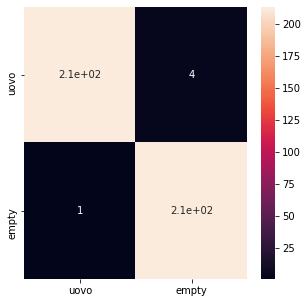

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

c = confusion_matrix(true_label,predicted)
df_cm = pd.DataFrame(c , index = ['uovo','empty'],
                  columns = ['uovo','empty'])
plt.figure(figsize = (5,5))
sn.heatmap(df_cm, annot=True)

#Riaddestro su tutto

In [ ]:
networkName = 'vgg11'
WeightPath = '/content/' + networkName + '/'

try:
  os.makedirs(WeightPath)
except:
  pass
  
model_conv = torchvision.models.vgg11(pretrained=True)
# change last fully connected layer
model_conv.classifier[6] = nn.Linear(4096, set_classes_number)

# set requires_grad=false
for param in model_conv.parameters():
  param.requires_grad = True
  
# train fully connected layers
for param in model_conv.classifier.parameters():
  param.requires_grad = True

print(model_conv)

model_conv = model_conv.cuda()
criterion = nn.CrossEntropyLoss()
# optimizer_conv = optim.Adam(model_conv.classifier.parameters(), lr=learning_rate)

#mat = sio.loadmat('/content/vgg11/check_point.mat')
# print(mat)
#best_epoca = int(mat['best_epoca'])
# print(best_epoca)

########################################################
image_datasets = datasets.ImageFolder(os.path.join(data_dir, 'DATI/TRAIN'),data_transforms['train_set_model'])
dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=batch_size,shuffle=True, num_workers=4)
dataset_sizes = len(image_datasets)
class_names = (image_datasets.classes)

# print(class_names)
# print(image_datasets.classes)
# print(dataset_sizes)

######################################################

# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, y),data_transforms[x]) for x,y in zip(['train_set_model', 'validation_set_model'],['tutto_tranne_7','7'])}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,shuffle=True, num_workers=4) for x in ['train_set_model', 'validation_set_model']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train_set_model', 'validation_set_model']}
# class_names = (image_datasets['train_set_model'].classes)

# -------------------------------------------------------------------------------------  train model
startEpoch =1
best_acc = 0
best_loss=0
best_epocaa = 0

train_loop(dataloaders, startEpoch, 44, model_conv, criterion, learning_rate, best_acc, best_loss, best_epocaa, WeightPath)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

##Predizione Kaggle

In [ ]:
Test = pd.DataFrame()

classes = class_names
#WeightPath = '/content/' + networkName


#model_conv = torchvision.models.googlenet(pretrained=True)
#model_conv.fc = nn.Linear(1024, set_classes_number)



listImage = os.listdir('/content/DATI/TEST_SET')


for input in listImage:
  Test = Test.append({'ID': input.split('.')[0]}, ignore_index = True)



for folder in folder_type:
  predizioni = []
  model_conv = torchvision.models.vgg11(pretrained=True)
  model_conv.classifier[6] = nn.Linear(4096, set_classes_number)
#model_conv.load_state_dict(torch.load(WeightPath + '/best_model_weights.pth'))
#model_conv.load_state_dict(torch.load('/content/vgg/definitive_model_weights.pth'))
  model_conv.load_state_dict(torch.load(f'/content/alexnet/best_model_weights_{folder}.pth'))
  model_conv = model_conv.cuda()
  model_conv.eval()

  data_transforms = transforms.Compose([transforms.Resize(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                        ])

  for input in listImage:
    print('Working on '+ input)
    img = Image.open('/content/DATI/TEST_SET/' + input)
    img = data_transforms(img).to(device)
    img = img.unsqueeze_(0)
    outputs = model_conv(img)
    _, predicted = torch.max(outputs, 1)
    # Test = Test.append({f'predicted_{str(i)}': (classes[predicted.item()])},
    #                    ignore_index = True)
    predizioni.append(classes[predicted.item()])
    


  Test[f'predizioni_{folder}'] = predizioni

predizioni_ok = []
for index, row in Test.iterrows():
  predizioni_temp = []
  for folder in folder_type:
    predizioni_temp.append(row[f'predizioni_{folder}'])
  predizioni_ok.append(most_common(predizioni_temp))
Test['Class'] = predizioni_ok

TestOk = Test[['ID','Class']]
  
#TestOk= Test.iloc[:, ::-1]

 #Convert the dataframe to a CSV Excel object.
TestOk.to_csv('gdrive/MyDrive/COLAB/10_newmodelstratified.csv',index=False)

  


#Predizione kaggle 2

In [ ]:
Test = pd.DataFrame()

classes = class_names
#WeightPath = '/content/' + networkName


#model_conv = torchvision.models.googlenet(pretrained=True)
#model_conv.fc = nn.Linear(1024, set_classes_number)



listImage = os.listdir('/content/DATI/TEST_SET')


for input in listImage:
  Test = Test.append({'ID': input.split('.')[0]}, ignore_index = True)




predizioni = []
model_conv = torchvision.models.vgg11(pretrained=True)
model_conv.classifier[6] = nn.Linear(4096, set_classes_number)
#model_conv.load_state_dict(torch.load(WeightPath + '/best_model_weights.pth'))
model_conv.load_state_dict(torch.load('/content/vgg11/def_model_weights.pth'))
#model_conv.load_state_dict(torch.load(f'/content/alexnet/best_model_weights_{folder}.pth'))
model_conv = model_conv.cuda()
model_conv.eval()

data_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                       ])

for input in listImage:
  print('Working on '+ input)
  img = Image.open('/content/DATI/TEST_SET/' + input)
  img = data_transforms(img).to(device)
  img = img.unsqueeze_(0)
  outputs = model_conv(img)
  _, predicted = torch.max(outputs, 1)
    # Test = Test.append({f'predicted_{str(i)}': (classes[predicted.item()])},
    #                    ignore_index = True)
  predizioni.append(classes[predicted.item()])
    


#   Test[f'predizioni_{folder}'] = predizioni

# predizioni_ok = []
# for index, row in Test.iterrows():
#   predizioni_temp = []
#   for folder in folder_type:
#     predizioni_temp.append(row[f'predizioni_{folder}'])
#   predizioni_ok.append(most_common(predizioni_temp))
Test['Class'] = predizioni

TestOk = Test[['ID','Class']]
  
#TestOk= Test.iloc[:, ::-1]

 #Convert the dataframe to a CSV Excel object.
TestOk.to_csv('gdrive/MyDrive/COLAB/last_classic_15.csv',index=False)

  


Working on 2_49.png
Working on 4_250.png
Working on 2_322.png
Working on 4_235.png
Working on 4_115.png
Working on 2_106.png
Working on 4_97.png
Working on 4_108.png
Working on 2_283.png
Working on 4_5.png
Working on K_17.png
Working on 2_240.png
Working on 4_324.png
Working on 4_286.png
Working on 4_228.png
Working on 2_155.png
Working on 2_134.png
Working on 4_291.png
Working on 4_207.png
Working on 4_301.png
Working on 2_111.png
Working on 4_325.png
Working on 4_360.png
Working on 2_169.png
Working on 2_87.png
Working on 2_91.png
Working on 4_125.png
Working on 2_40.png
Working on 4_74.png
Working on 2_294.png
Working on 2_100.png
Working on 2_271.png
Working on 4_80.png
Working on 2_298.png
Working on 2_196.png
Working on 2_220.png
Working on 2_235.png
Working on 4_122.png
Working on 4_208.png
Working on 4_225.png
Working on 2_189.png
Working on 2_183.png
Working on 2_20.png
Working on 4_359.png
Working on 4_243.png
Working on 2_184.png
Working on 4_148.png
Working on 2_305.png
Wor